## Understanding the Data

In [1]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import joblib
import json



In [2]:
df = pd.read_csv(r"C:\Users\04ama\Downloads\raw adhd data\raw_data.csv")
quant_data = pd.read_excel(r"C:\Users\04ama\Downloads\TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat_data = pd.read_excel(r"C:\Users\04ama\Downloads\TRAIN_CATEGORICAL_METADATA_new.xlsx")
conn_data = pd.read_csv(r"C:\Users\04ama\Downloads\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson (1).csv")


In [3]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")


Dataset shape: (1213, 19929)
Columns: 19929


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19929 entries, participant_id to ADHD_Outcome
dtypes: float64(19925), int64(3), object(1)
memory usage: 184.4+ MB


In [5]:
# Add this to your Data Merging notebook after merging
print("=== SPARSITY ANALYSIS ===")

# Check missing values
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
sparsity_percentage = (missing_cells / total_cells) * 100

print(f"Dataset shape: {df.shape}")
print(f"Total cells: {total_cells:,}")
print(f"Missing cells: {missing_cells:,}")
print(f"Sparsity: {sparsity_percentage:.7f}%")

# Check sparsity by column type
print(f"\n=== MISSING VALUES BY COLUMN TYPE ===")
quant_cols = [col for col in df.columns if col.startswith('APQ_') or col.startswith('SDQ_') or col.startswith('EHQ_') or col.startswith('ColorVision')]
cat_cols = [col for col in df.columns if col.startswith('PreInt_') or col.startswith('Basic_')]
conn_cols = [col for col in df.columns if col not in quant_cols + cat_cols + ['participant_id', 'ADHD_Outcome', 'Sex_F']]

print(f"Quantitative columns missing: {df[quant_cols].isnull().sum().sum()}/{len(quant_cols) * df.shape[0]} ({(df[quant_cols].isnull().sum().sum()/(len(quant_cols) * df.shape[0]))*100:.2f}%)")
print(f"Categorical columns missing: {df[cat_cols].isnull().sum().sum()}/{len(cat_cols) * df.shape[0]} ({(df[cat_cols].isnull().sum().sum()/(len(cat_cols) * df.shape[0]))*100:.2f}%)")
print(f"Connectome columns missing: {df[conn_cols].isnull().sum().sum()}/{len(conn_cols) * df.shape[0]} ({(df[conn_cols].isnull().sum().sum()/(len(conn_cols) * df.shape[0]))*100:.2f}%)")

# Show columns with highest missing percentages
print(f"\n=== COLUMNS WITH MOST MISSING VALUES ===")
missing_by_col = df.isnull().sum().sort_values(ascending=False)
high_missing = missing_by_col[missing_by_col > 0]
if len(high_missing) > 0:
    for col, missing_count in high_missing.head(10).items():
        missing_pct = (missing_count / df.shape[0]) * 100
        print(f"{col}: {missing_count}/{df.shape[0]} ({missing_pct:.1f}%)")
else:
    print("No missing values found!")

=== SPARSITY ANALYSIS ===
Dataset shape: (1213, 19929)
Total cells: 24,173,877
Missing cells: 1,115
Sparsity: 0.0046124%

=== MISSING VALUES BY COLUMN TYPE ===
Quantitative columns missing: 189/20621 (0.92%)
Categorical columns missing: 97/4852 (2.00%)
Connectome columns missing: 829/24145978 (0.00%)

=== COLUMNS WITH MOST MISSING VALUES ===
MRI_Track_Age_at_Scan: 360/1213 (29.7%)
Barratt_Barratt_P2_Occ: 222/1213 (18.3%)
Barratt_Barratt_P2_Edu: 198/1213 (16.3%)
PreInt_Demos_Fam_Child_Race: 54/1213 (4.5%)
PreInt_Demos_Fam_Child_Ethnicity: 43/1213 (3.5%)
Barratt_Barratt_P1_Occ: 31/1213 (2.6%)
ColorVision_CV_Score: 23/1213 (1.9%)
Barratt_Barratt_P1_Edu: 15/1213 (1.2%)
EHQ_EHQ_Total: 13/1213 (1.1%)
APQ_P_APQ_P_INV: 12/1213 (1.0%)


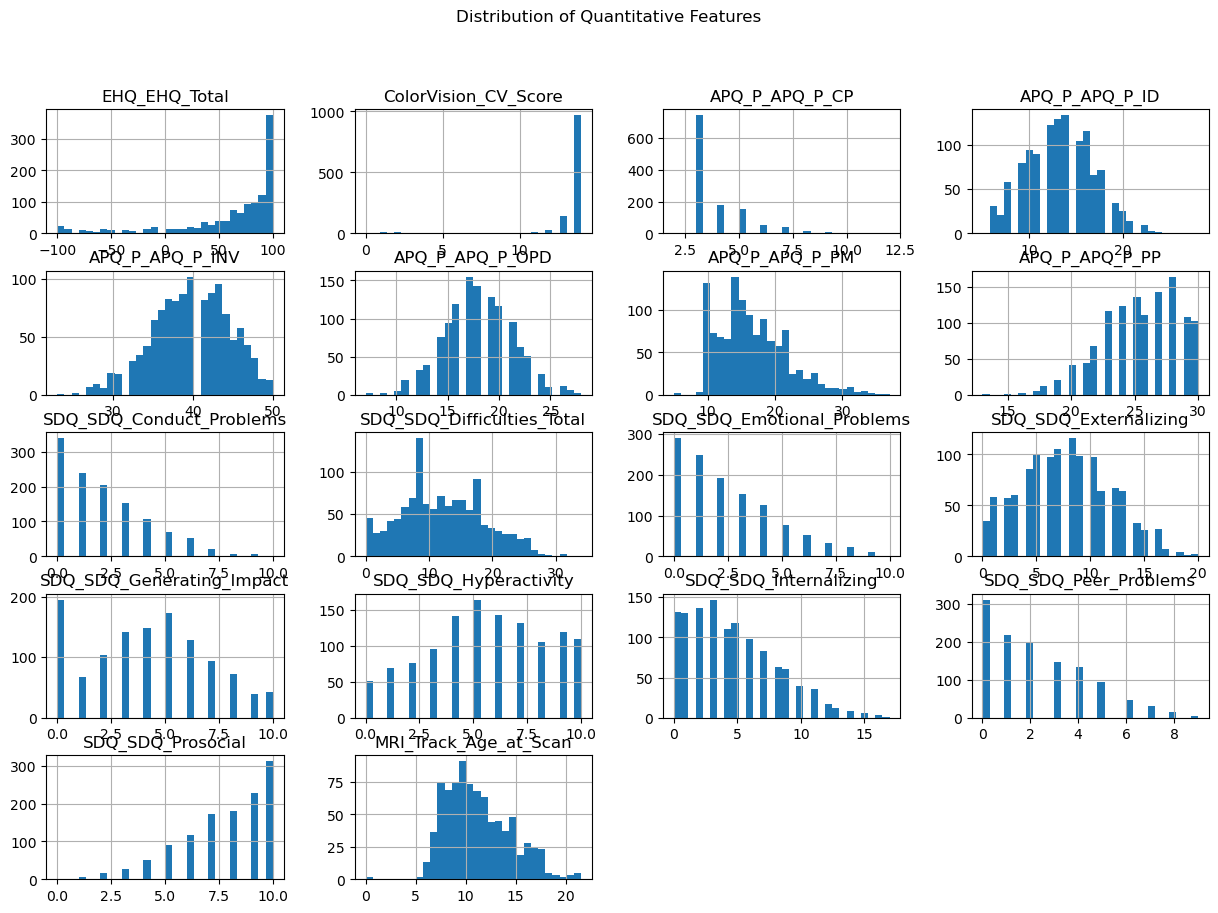

In [6]:
#check the distirbution of the quant_data with histograms

quant_data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Quantitative Features")
plt.show()


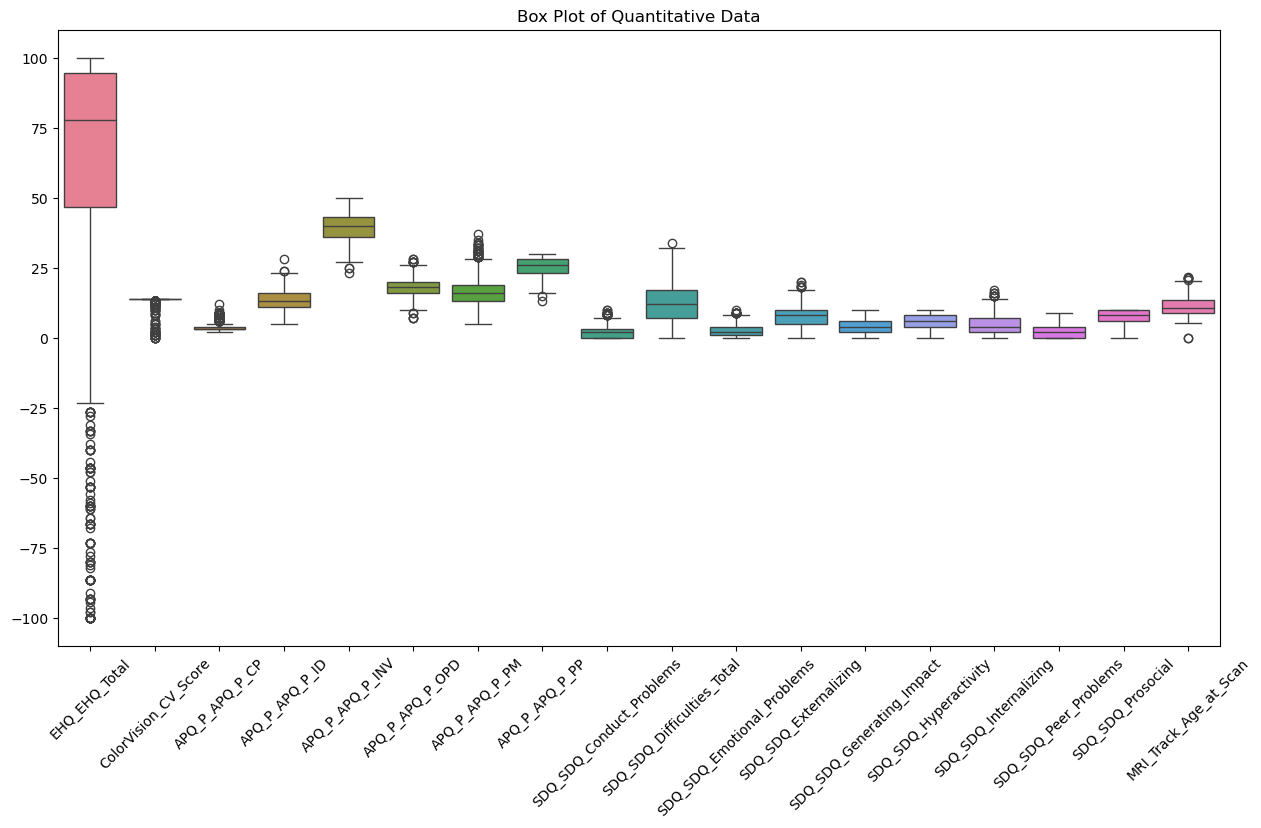

In [7]:
#check outliers in quant data with box plots
quant_data = quant_data.drop(columns=['participant_id'],axis=1, errors='ignore')
plt.figure(figsize=(15, 8))
sns.boxplot(data=quant_data)
plt.title("Box Plot of Quantitative Data")
plt.xticks(rotation=45)
plt.show()

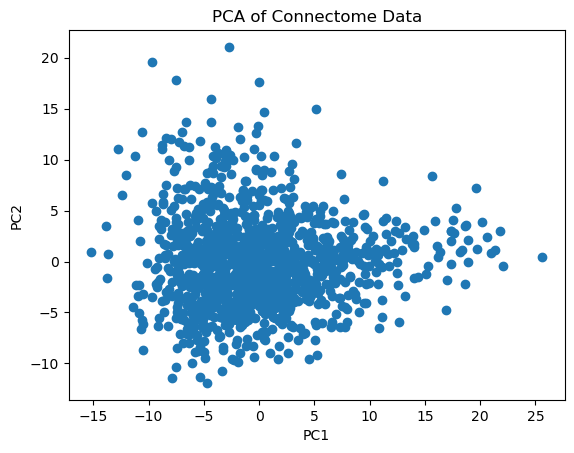

In [8]:
# visualise the connectome data using PCA
from sklearn.decomposition import PCA
# drop non-numeric columns if any
conn_data = conn_data.drop(columns=['participant_id'],axis=1, errors='ignore')
pca = PCA(n_components=2)
conn_data_pca = pca.fit_transform(conn_data)
plt.scatter(conn_data_pca[:,0], conn_data_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Connectome Data')
plt.show()




In [9]:
def handedness_group(score):
    if score <= -0.5:
        return 'Left'
    elif score >= 0.5:
        return 'Right'
    else:
        return 'Ambidextrous'

cat_data['Handedness_Group'] = quant_data['EHQ_EHQ_Total'].apply(handedness_group)
df['Handedness_Group'] = df['EHQ_EHQ_Total'].apply(handedness_group)


In [10]:

# change data type to numerical
df['Handedness_Group'] = df['Handedness_Group'].astype('category').cat.codes

In [11]:
# Connectome columns: columns 1 to 19901 (Python end-exclusive)
conn_cols = list(df.iloc[:, 1:19901].columns)

# Quantitative columns: columns 19902 to 19920
quant_cols = list(df.iloc[:, 19902:19921].columns)

# Categorical columns: columns 19921 to the end
cat_cols = list(df.iloc[:, 19921:].columns)

In [12]:
print(f"\nFeature groups:")
print(f"Connectome features: {len(conn_cols)}")
print(f"Quantitative features: {len(quant_cols)}")
print(f"Categorical features: {len(cat_cols)}")



Feature groups:
Connectome features: 19900
Quantitative features: 19
Categorical features: 9


In [16]:


# Standardize quantitative columns
def standardise_quant(df, quant_cols):
    scaler = StandardScaler()
    df[quant_cols] = scaler.fit_transform(df[quant_cols])
    return df
# KNN imputation
def knn_impute(df, cols):
    imputer = KNNImputer(n_neighbors=5)
    df[cols] = imputer.fit_transform(df[cols])
    return df

# One-hot encode categorical columns
def one_hot_encode(df, cat_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
    df = df.drop(columns=cat_cols)
    df = pd.concat([df, encoded_df], axis=1)
    return df

#  PCA for connectome matrix
def pca_connectome(df, conn_cols, n_components=10):
    pca = PCA(n_components=n_components)
    conn_pca = pca.fit_transform(df[conn_cols])
    pca_cols = [f'conn_pca_{i+1}' for i in range(n_components)]
    conn_pca_df = pd.DataFrame(conn_pca, columns=pca_cols, index=df.index)
    df = df.drop(columns=conn_cols)
    df = pd.concat([df, conn_pca_df], axis=1)
    explained_var = pca.explained_variance_ratio_
    total_var = explained_var.sum()
    print(f"Variance explained by each  Connectome component: {explained_var}")
    print(f"Total variance explained by {pca.n_components} components: {total_var:.2%}")

    return df




In [17]:
df = standardise_quant(df, quant_cols)
# Convert 'Handedness_Group' to numerical codes for KNN imputation
df['Handedness_Group'] = df['Handedness_Group'].astype('category').cat.codes
df = knn_impute(df, quant_cols + cat_cols)
df['MRI_Track_Age_at_Scan'] = df['MRI_Track_Age_at_Scan'].round().astype(int)
df = one_hot_encode(df, cat_cols)
df = pca_connectome(df, conn_cols)

KeyError: 'Handedness_Group'

## Save preprocessed data 

In [15]:
df.to_csv('processed_data.csv', index=False)

# Done